In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from luprox import linear_uncertainty, mc_uncertainty

In [3]:
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import random, vmap
from jax.nn import sigmoid, relu

In [4]:
# Test function
def f(x):
    return (1/(1+jnp.abs(0.3*x)**2))

# Settings
test_point = jnp.array([2.])
cov_x = jnp.array([[0.05]]) # Covariance matrix for x (scalar for 1D random variables)
x_vec = jnp.linspace(-10,10,1000)
x_array = jnp.expand_dims(x_vec, axis=1)

# Random seed
key = random.PRNGKey(42)

In [5]:
# Add linear uncertainty estimation to f
f_up_approx = linear_uncertainty(f)

# Add Monte Carlo uncertainty estimation to f
f_up_mc = mc_uncertainty(f, trials=1000)

In [6]:
# Test on a single sample
mu_linear, cov_linear = f_up_approx(test_point, cov_x)
mu_mc, cov_mc = f_up_mc(test_point, cov_x, key)

print("STD: {} (Linear) | {} (Monte Carlo)".format(
    jnp.sqrt(cov_linear[0,0]), 
    jnp.sqrt(cov_mc)
))

STD: 0.04352208226919174 (Linear) | 0.04308144003152847 (Monte Carlo)


In [7]:
# Composing with jax transformation
f_hat = vmap(f_up_approx, in_axes=(0,None))
f_mc =  vmap(f_up_mc,     in_axes=(0,None, None))

In [8]:
y_linear, cov_y_mat = f_hat(x_array, cov_x)
ci_linear = jnp.sqrt(cov_y_mat[:,0,0])*3 # 3 sigma
y_linear = y_linear[:,0]

In [9]:
y_mc, cov_y_mat = f_mc(x_array, cov_x, key)
ci_mc = jnp.sqrt(cov_y_mat)*3 # 3 sigma
y_mc = y_mc[:,0]

Text(0.5, 1.0, 'Monte Carlo (N=1000)')

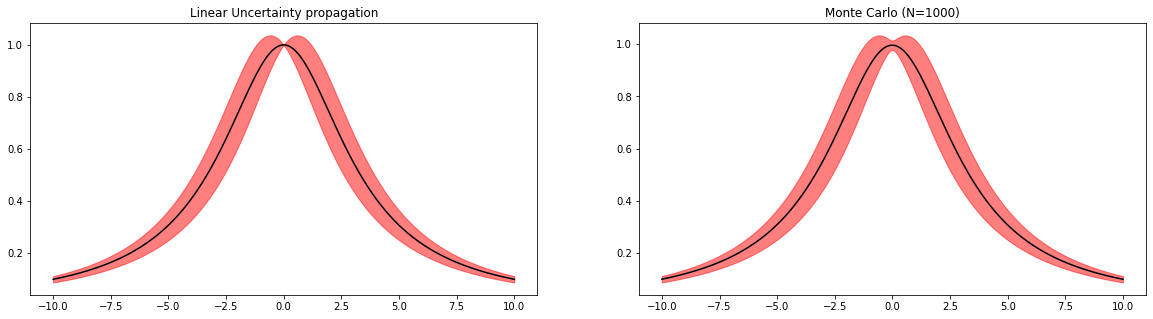

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_vec, y_linear, color="black")
ax[0].fill_between(x_vec, y_linear-ci_linear, y_linear+ci_linear, color="red", alpha=0.5)
ax[0].set_title("Linear Uncertainty propagation")

ax[1].plot(x_vec, y_mc, color="black")
ax[1].fill_between(x_vec, y_mc-ci_mc, y_mc+ci_mc, color="red", alpha=0.5)
ax[1].set_title("Monte Carlo (N=1000)")

In [11]:
%%timeit 
f_hat(x_array+0.2, cov_x)[1].block_until_ready()

645 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit 
f_mc(x_array+0.2, cov_x, key)[1].block_until_ready()

683 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
